# D-POL-2 — Specialty Pattern Shift

**Decision:** D-POL-2 — Specialty Pattern Shift  
**Actor:** POL — Policy  
**Decision Owner:** Medical Review Director / CPI Policy Analyst  
**Version:** 1.0  
**Date:** February 2026  

---

## What This Notebook Does

This notebook analyzes specialty-level billing patterns among the 3,182 providers
assigned to OIG/DOJ Referral and Targeted Probe and Educate pathways in D-PI-2,
using code-level scrutiny outputs from D-POL-1.

Two analytical tracks are executed:

**Track 1 — Cross-Specialty Pattern Comparison (Data Year 2023)**  
Identifies which Provider Type specialties are disproportionately represented
among anomalous code billing patterns. Fully executable from existing outputs.

**Track 2 — Intra-Specialty Temporal Shift Framework (Baseline Only)**  
Establishes Data Year 2023 as the reference baseline for future temporal shift
detection. Framework is complete and parameterized. Temporal detection requires
Data Year 2024 or later. All Track 2 outputs are tagged Assumed (A) and resolve
to Derived (D) when multi-year data becomes available.

## What This Notebook Does NOT Do

- Assert provider intent, fraud, waste, or abuse
- Execute temporal shift detection (data-constrained at single year)
- Produce claims-level findings
- Replace human judgment by named Decision Owners

## Upstream Dependencies

| File | Source |
|---|---|
| `code_scrutiny_flags_v1.parquet` | D-POL-1 |
| `top_codes_by_frequency_v1.parquet` | D-POL-1 |
| `top_codes_by_exposure_v1.parquet` | D-POL-1 |
| `escalation_pathway_v1.parquet` | D-PI-2 |
| `provider_tiered_v1.parquet` | D-PI-1 |
| `provider_rollup_v1.parquet` | D-PI-1 |

---

## Legal and Use Disclaimer

This notebook is part of an independent analytical portfolio project.
It is not affiliated with, endorsed by, or produced in cooperation with
CMS, HHS, OIG, or any federal, state, or local government agency.
All data is publicly available. No outputs constitute actionable findings,
referrals, or recommendations under any federal statute.
Analytical outputs describe statistical patterns in publicly available
billing data only.

In [17]:
# DPOL2-00-CONFIG-01
# Configuration — all imports, paths, parameters, and CVD palette
# No hardcoded variables elsewhere in this notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path

# ---------------------------------------------------------------------------
# PROJECT PATHS
# ---------------------------------------------------------------------------
PROJECT_ROOT  = Path(r'C:\Users\billm\Projects\Medicare\medicare-program-integrity')
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
OUTPUTS_DIR   = PROJECT_ROOT / 'outputs'
FIGURES_DIR   = OUTPUTS_DIR / 'figures'
BRIEFS_DIR    = OUTPUTS_DIR / 'decision_briefs'
DECISION_DIR  = PROJECT_ROOT / 'decisions' / 'D-POL-2_specialty_shift'

# ---------------------------------------------------------------------------
# SCOPE PARAMETERS
# ---------------------------------------------------------------------------
TARGET_PATHWAYS = ['OIG/DOJ Referral', 'Targeted Probe and Educate']
# Rationale: Consistent with D-POL-1 input scope (DL-DPOL1-01)
# EdLetter providers excluded — specialty scrutiny not warranted at that pathway

MIN_SPECIALTY_SIZE = 10
# Rationale: Minimum providers per specialty for reliable concentration scoring
# Inherited from PROJECT_STANDARDS Rule 7 — MIN_SUBGROUP_SIZE
# Specialties below this threshold receive neutral score 0.50

TOP_N_DISPLAY = 20
# Rationale: Consistent with D-POL-1 TOP_N_DISPLAY=20 (DL-DPOL1-10)
# Provides actionable policy target list without overwhelming visualization

# ---------------------------------------------------------------------------
# TRACK 1 SCORING PARAMETERS
# ---------------------------------------------------------------------------
S1_CONCENTRATION_THRESHOLD = 0.0075
# Rationale: Natural break identified in full specialty distribution
# (DPOL2-04-SCORE-01 diagnostic). Separates top 10 specialties with
# meaningfully elevated concentration from the broader distribution.
# Specialties above this threshold have roughly 1 in 130 or more
# providers flagged as anomalous. Tag D — derived from observed distribution.
# Data Year 2023 baseline. (DL-DPOL2-05)

S2_PATHWAY_RATIO_THRESHOLD = 0.35
# Rationale: Natural break identified in full reliable specialty distribution
# (DPOL2-04-SCORE-02 diagnostic). Separates specialties where more than
# 1 in 3 flagged providers routes to OIG/DOJ Referral from the broader
# distribution. Tag D — derived from observed distribution.
# Data Year 2023 baseline. (DL-DPOL2-06)

# ---------------------------------------------------------------------------
# TRACK 2 PARAMETERS — DATA-CONSTRAINED
# ---------------------------------------------------------------------------
S4_SHIFT_MAGNITUDE_THRESHOLD = 0.20
# PROVISIONAL — tag A — DATA-CONSTRAINED
# Rationale: A 20% shift in specialty baseline metric between data years
# represents a meaningful pattern change warranting policy review
# Recalibrate when Data Year 2024 or later is available

S4_MIN_PROVIDER_COUNT = 10
# Rationale: Minimum providers per specialty per data year for reliable
# shift detection; consistent with MIN_SPECIALTY_SIZE

BASELINE_YEAR = 2023
# Rationale: Data Year 2023 is the single available reference year
# All temporal outputs are tagged A until second data year is available

# ---------------------------------------------------------------------------
# NEUTRAL SCORE
# ---------------------------------------------------------------------------
NEUTRAL_SCORE = 0.50
# Rationale: Assigned to specialties below MIN_SPECIALTY_SIZE
# Consistent with PROJECT_STANDARDS Rule 7

# ---------------------------------------------------------------------------
# REPRODUCIBILITY
# ---------------------------------------------------------------------------
RANDOM_STATE = 42   # Industry-standard reproducibility seed

# ---------------------------------------------------------------------------
# CVD-COMPLIANT PALETTE — IBM Carbon
# ---------------------------------------------------------------------------
CVD_PALETTE = {
    'tier1_oig'   : '#DC267F',   # Magenta  — OIG/DOJ Referral
    'tier2_tpe'   : '#FFB000',   # Amber    — Targeted Probe and Educate
    'tier3_edltr' : '#648FFF',   # Blue     — Provider Education Letter
    'no_flag'     : '#BBBBBB',   # Gray     — No flag / neutral
}

print('CONFIG loaded successfully.')
print(f'Project root : {PROJECT_ROOT}')
print(f'Processed dir: {PROCESSED_DIR}')
print(f'Figures dir  : {FIGURES_DIR}')
print(f'Track 1 — S1 concentration threshold : {S1_CONCENTRATION_THRESHOLD} (PROVISIONAL)')
print(f'Track 1 — S2 pathway ratio threshold : {S2_PATHWAY_RATIO_THRESHOLD} (PROVISIONAL)')
print(f'Track 2 — S4 shift magnitude threshold: {S4_SHIFT_MAGNITUDE_THRESHOLD} (PROVISIONAL — data-constrained)')
print(f'Baseline year: {BASELINE_YEAR}')

CONFIG loaded successfully.
Project root : C:\Users\billm\Projects\Medicare\medicare-program-integrity
Processed dir: C:\Users\billm\Projects\Medicare\medicare-program-integrity\data\processed
Figures dir  : C:\Users\billm\Projects\Medicare\medicare-program-integrity\outputs\figures
Track 1 — S1 concentration threshold : 0.0075 (PROVISIONAL)
Track 1 — S2 pathway ratio threshold : 0.35 (PROVISIONAL)
Track 2 — S4 shift magnitude threshold: 0.2 (PROVISIONAL — data-constrained)
Baseline year: 2023


<!-- DPOL2-01-LOAD-00 -->
## Section 1 — Data Load

Load all upstream dependency files. No transformations in this section.
Load and confirm row counts only.

In [2]:
# DPOL2-01-LOAD-01
# Load all upstream dependency files — no transformations

# D-POL-1 outputs
df_flags    = pd.read_parquet(PROCESSED_DIR / 'code_scrutiny_flags_v1.parquet')
df_freq     = pd.read_parquet(PROCESSED_DIR / 'top_codes_by_frequency_v1.parquet')
df_exposure = pd.read_parquet(PROCESSED_DIR / 'top_codes_by_exposure_v1.parquet')

# D-PI-2 output
df_pathway  = pd.read_parquet(PROCESSED_DIR / 'escalation_pathway_v1.parquet')

# D-PI-1 outputs
df_tiered   = pd.read_parquet(PROCESSED_DIR / 'provider_tiered_v1.parquet')
df_rollup   = pd.read_parquet(PROCESSED_DIR / 'provider_rollup_v1.parquet')

print('=== Load Confirmation ===')
print(f'df_flags    : {len(df_flags):>10,} rows | {df_flags.shape[1]} cols | D-POL-1 code scrutiny flags')
print(f'df_freq     : {len(df_freq):>10,} rows | {df_freq.shape[1]} cols | D-POL-1 top codes by frequency')
print(f'df_exposure : {len(df_exposure):>10,} rows | {df_exposure.shape[1]} cols | D-POL-1 top codes by exposure')
print(f'df_pathway  : {len(df_pathway):>10,} rows | {df_pathway.shape[1]} cols | D-PI-2 escalation pathway')
print(f'df_tiered   : {len(df_tiered):>10,} rows | {df_tiered.shape[1]} cols | D-PI-1 full provider population')
print(f'df_rollup   : {len(df_rollup):>10,} rows | {df_rollup.shape[1]} cols | D-PI-1 provider rollup')

=== Load Confirmation ===
df_flags    :      3,182 rows | 10 cols | D-POL-1 code scrutiny flags
df_freq     :      1,886 rows | 7 cols | D-POL-1 top codes by frequency
df_exposure :      1,886 rows | 7 cols | D-POL-1 top codes by exposure
df_pathway  :     22,400 rows | 14 cols | D-PI-2 escalation pathway
df_tiered   :    970,848 rows | 25 cols | D-PI-1 full provider population
df_rollup   :  1,175,281 rows | 15 cols | D-PI-1 provider rollup


<!-- DPOL2-02-VALIDATE-00 -->
## Section 2 — Data Validation

Four integrity checks before processing begins.
All checks must pass before proceeding to PREP section.


In [3]:
# DPOL2-02-VALIDATE-01
# Data integrity checks — all four must pass before scoring begins

print('=== Validation Checks ===')

# Check 1 — No duplicate NPIs in flags
dup_npis = df_flags['Rndrng_NPI'].duplicated().sum()
assert dup_npis == 0, f'FAIL: {dup_npis} duplicate NPIs in df_flags'
print(f'CHECK 1 PASS — No duplicate NPIs in df_flags ({len(df_flags):,} unique providers)')

# Check 2 — Pathway distribution matches D-PI-2 documented results
# NOTE: Values 655 and 2527 are Data Year 2023 validated results sourced from
#       D-PI-2 evidence log entry E-DPI2-05 and decision log entry DL-DPI2-10.
#       These are validation checkpoints, not operational thresholds.
#       If data year is updated, recalibrate D-PI-2 first and update these
#       values to match the new documented pathway counts before re-running.
oig_count = (df_pathway['pathway'] == 'OIG/DOJ Referral').sum()
tpe_count = (df_pathway['pathway'] == 'Targeted Probe and Educate').sum()
assert oig_count == 655,  f'FAIL: OIG count {oig_count} does not match expected 655 (Data Year 2023)'
assert tpe_count == 2527, f'FAIL: TPE count {tpe_count} does not match expected 2527 (Data Year 2023)'
print(f'CHECK 2 PASS — Pathway distribution confirmed: OIG={oig_count:,} | TPE={tpe_count:,}')

# Check 3 — Provider Type present for all flagged providers
provtype_col = [c for c in df_tiered.columns if 'Type' in c and 'Prvdr' in c][0]
tiered_npis  = set(df_tiered['Rndrng_NPI'].astype(str))
flags_npis   = set(df_flags['Rndrng_NPI'].astype(str))
missing_type = flags_npis - tiered_npis
assert len(missing_type) == 0, f'FAIL: {len(missing_type)} flagged NPIs missing from df_tiered'
print(f'CHECK 3 PASS — All flagged NPIs present in df_tiered with Provider Type')

# Check 4 — No null Provider Types in population denominator
null_types = df_tiered[provtype_col].isnull().sum()
assert null_types == 0, f'FAIL: {null_types} null Provider Types in df_tiered'
print(f'CHECK 4 PASS — No null Provider Types in population denominator')

print(f'\nProvider Type column identified: {provtype_col}')
print('\nAll validation checks passed. Proceeding to PREP section.')

=== Validation Checks ===
CHECK 1 PASS — No duplicate NPIs in df_flags (3,182 unique providers)
CHECK 2 PASS — Pathway distribution confirmed: OIG=655 | TPE=2,527
CHECK 3 PASS — All flagged NPIs present in df_tiered with Provider Type
CHECK 4 PASS — No null Provider Types in population denominator

Provider Type column identified: Rndrng_Prvdr_Type

All validation checks passed. Proceeding to PREP section.


<!-- DPOL2-03-PREP-00 -->
## Section 3 — Data Preparation

Two preparation cells — one per track.

**DPOL2-03-PREP-01** builds the Track 1 working dataset:
joins flagged providers to full specialty population denominators
and pathway assignments.

**DPOL2-03-PREP-02** builds the Track 2 baseline dataset:
aggregates provider_rollup_v1 by Provider Type to produce
Data Year 2023 specialty-level baseline metrics.

**Population denominator note:** Full provider_tiered_v1 population
is used as the specialty denominator — not the flagged subset.
This ensures concentration ratios reflect the true share of each
specialty that exhibits anomalous patterns. (DL-DPOL2-04)

In [6]:
# DPOL2-03-PREP-01
# Track 1 working dataset — flagged providers with specialty assignments
# and full population denominators
# NOTE: df_flags already contains pathway and composite_score from D-POL-1
#       No pathway join required — columns present from upstream output

# Get Provider Type for flagged providers from df_tiered
specialty_lookup = df_tiered[['Rndrng_NPI', provtype_col]].drop_duplicates(subset='Rndrng_NPI')

# Build Track 1 working dataset — join specialty only
df_specialty = (
    df_flags
    .merge(specialty_lookup, on='Rndrng_NPI', how='left')
)

# Rename Provider Type column for clarity
df_specialty = df_specialty.rename(columns={provtype_col: 'provider_type'})

# Full specialty population denominators from df_tiered
specialty_population = (
    df_tiered
    .rename(columns={provtype_col: 'provider_type'})
    .groupby('provider_type')['Rndrng_NPI']
    .nunique()
    .reset_index()
    .rename(columns={'Rndrng_NPI': 'specialty_total_providers'})
)

df_specialty = df_specialty.merge(specialty_population, on='provider_type', how='left')

# Validation
null_types   = df_specialty['provider_type'].isnull().sum()
null_pathway = df_specialty['pathway'].isnull().sum()
assert null_types == 0,   f'FAIL: {null_types} null provider types in df_specialty'
assert null_pathway == 0, f'FAIL: {null_pathway} null pathways in df_specialty'

print('=== Track 1 Working Dataset ===')
print(f'df_specialty rows       : {len(df_specialty):,}')
print(f'Unique providers        : {df_specialty["Rndrng_NPI"].nunique():,}')
print(f'Unique Provider Types   : {df_specialty["provider_type"].nunique():,}')
print(f'Null provider types     : {null_types}')
print(f'Null pathway assignments: {null_pathway}')
print(f'Columns                 : {list(df_specialty.columns)}')

=== Track 1 Working Dataset ===
df_specialty rows       : 3,182
Unique providers        : 3,182
Unique Provider Types   : 74
Null provider types     : 0
Null pathway assignments: 0
Columns                 : ['Rndrng_NPI', 'pathway', 'composite_score', 'c1_flag', 'c2_flag_count', 'c3_flag', 'c4_flag_count', 'total_allowed', 'total_codes_billed', 'dimensions_flagged', 'provider_type', 'specialty_total_providers']


In [7]:
# DPOL2-03-PREP-02
# Track 2 baseline dataset — specialty-level aggregate metrics
# Data Year 2023 reference only — tag A (data-constrained)

# Identify required columns in df_rollup
rollup_provtype_col = [c for c in df_rollup.columns if 'Type' in c and 'Prvdr' in c][0]
print(f'Provider Type column in df_rollup: {rollup_provtype_col}')

# Check available metric columns in df_rollup
print(f'df_rollup columns: {list(df_rollup.columns)}')

Provider Type column in df_rollup: Rndrng_Prvdr_Type
df_rollup columns: ['Rndrng_NPI', 'Rndrng_Prvdr_Type', 'Tot_Benes_sum', 'Tot_Srvcs_sum', 'allowed_dollars_sum', 'payment_dollars_sum', 'submitted_dollars_sum', 'S3_services_per_bene', 'S1_allowed_per_bene', 'S2_payment_per_bene', 'S4_submitted_to_allowed_ratio', 'S6_payment_to_allowed_ratio', 'S7_allowed_minus_payment_per_bene', 'S5a_top1_allowed_share', 'S5b_top1_payment_share']


In [8]:
# DPOL2-03-PREP-02
# Track 2 baseline dataset — specialty-level aggregate metrics
# Data Year 2023 reference only — tag A (data-constrained)

# Aggregate by Provider Type — three baseline metrics
df_baseline = (
    df_rollup
    .rename(columns={rollup_provtype_col: 'provider_type'})
    .groupby('provider_type')
    .agg(
        provider_count           = ('Rndrng_NPI',          'nunique'),
        median_allowed_per_bene  = ('S1_allowed_per_bene', 'median'),
        median_services_per_bene = ('S3_services_per_bene','median'),
        median_top1_share        = ('S5a_top1_allowed_share','median'),
    )
    .reset_index()
)

df_baseline['baseline_year'] = BASELINE_YEAR
# Tag A — single data year; resolves to D when multi-year data available

# Reliability flag — specialties with sufficient providers for baseline
df_baseline['s3_baseline_complete'] = (
    df_baseline['provider_count'] >= S4_MIN_PROVIDER_COUNT
).astype(int)

reliable   = df_baseline['s3_baseline_complete'].sum()
unreliable = len(df_baseline) - reliable

print('=== Track 2 Baseline Dataset (tag A — data-constrained) ===')
print(f'df_baseline rows                  : {len(df_baseline):,}')
print(f'Unique Provider Types             : {df_baseline["provider_type"].nunique():,}')
print(f'Reliable baselines (>= {S4_MIN_PROVIDER_COUNT} providers): {reliable:,}')
print(f'Unreliable baselines              : {unreliable:,}')
print(f'Baseline year                     : {BASELINE_YEAR}')
print(f'\nNOTE: Tag A — single data year. Resolves to D when multi-year data available.')
print(f'\nBaseline summary statistics:')
print(df_baseline[[
    'median_allowed_per_bene',
    'median_services_per_bene',
    'median_top1_share'
]].describe().round(4))

=== Track 2 Baseline Dataset (tag A — data-constrained) ===
df_baseline rows                  : 104
Unique Provider Types             : 104
Reliable baselines (>= 10 providers): 101
Unreliable baselines              : 3
Baseline year                     : 2023

NOTE: Tag A — single data year. Resolves to D when multi-year data available.

Baseline summary statistics:
       median_allowed_per_bene  median_services_per_bene  median_top1_share
count                 104.0000                  104.0000           104.0000
mean                  110.3997                    2.7523             0.4724
std                    83.6041                    4.9783             0.1806
min                    20.1420                    1.0000             0.2010
25%                    78.1021                    1.1177             0.3481
50%                    98.8144                    1.4383             0.4360
75%                   116.5769                    1.9889             0.5631
max                   

<!-- DPOL2-04-SCORE-00 -->
## Section 4 — Dimension Scoring

Four dimensions across two tracks:

| Dimension | Track | Description | Tag |
|---|---|---|---|
| S1 — Specialty Anomaly Concentration | Track 1 | Flagged provider share by specialty | D |
| S2 — Pathway Stratification by Specialty | Track 2 | OIG vs TPE distribution by specialty | D |
| S3 — Specialty Norm Baseline | Track 2 | Data Year 2023 baseline metrics | A |
| S4 — Shift Detection Threshold Design | Track 2 | Parameterized shift detection framework | A |

In [14]:
# DPOL2-04-SCORE-01
# S1 — Specialty Anomaly Concentration (Track 1 — tag D)
# Flagged provider share by Provider Type specialty

# Count flagged providers per specialty
specialty_flagged = (
    df_specialty
    .groupby('provider_type')['Rndrng_NPI']
    .nunique()
    .reset_index()
    .rename(columns={'Rndrng_NPI': 'flagged_provider_count'})
)

# Join population denominators
specialty_flagged = specialty_flagged.merge(specialty_population, on='provider_type', how='left')

# Compute flagged share
specialty_flagged['specialty_flagged_share'] = (
    specialty_flagged['flagged_provider_count'] /
    specialty_flagged['specialty_total_providers']
).round(4)

# Apply neutral score for specialties below MIN_SPECIALTY_SIZE
specialty_flagged['s1_concentration_flag'] = np.where(
    specialty_flagged['flagged_provider_count'] < MIN_SPECIALTY_SIZE,
    NEUTRAL_SCORE,
    (specialty_flagged['specialty_flagged_share'] >= S1_CONCENTRATION_THRESHOLD).astype(int)
)

neutral_s1 = (specialty_flagged['s1_concentration_flag'] == NEUTRAL_SCORE).sum()
flagged_s1 = (specialty_flagged['s1_concentration_flag'] == 1).sum()

print('=== S1 — Specialty Anomaly Concentration ===')
print(f'Specialties scored      : {len(specialty_flagged):,}')
print(f'Neutral assignments     : {neutral_s1} (flagged count < {MIN_SPECIALTY_SIZE})')
print(f'S1 flagged specialties  : {flagged_s1}')
print(f'Threshold applied       : {S1_CONCENTRATION_THRESHOLD} (tag D)')
print(f'\nTop 10 specialties by flagged share:')
print(
    specialty_flagged
    .sort_values('specialty_flagged_share', ascending=False)
    [['provider_type', 'flagged_provider_count', 'specialty_total_providers', 'specialty_flagged_share']]
    .head(10)
    .to_string(index=False)
)

=== S1 — Specialty Anomaly Concentration ===
Specialties scored      : 74
Neutral assignments     : 32 (flagged count < 10)
S1 flagged specialties  : 9
Threshold applied       : 0.0075 (tag D)

Top 10 specialties by flagged share:
                  provider_type  flagged_provider_count  specialty_total_providers  specialty_flagged_share
                    Hospitalist                     241                      17729                   0.0136
                General Surgery                     178                      15640                   0.0114
   Mass Immunizer Roster Biller                     260                      26981                   0.0096
       Interventional Radiology                      18                       2141                   0.0084
                    Dermatology                      94                      11865                   0.0079
              Pulmonary Disease                      76                       9743                   0.0078
           Di

In [18]:
# DPOL2-04-SCORE-02
# S2 — Pathway Stratification by Specialty (Track 1 — tag D)
# OIG vs TPE distribution by specialty

# Count OIG and TPE providers per specialty
pathway_by_specialty = (
    df_specialty
    .groupby(['provider_type', 'pathway'])['Rndrng_NPI']
    .nunique()
    .reset_index()
    .rename(columns={'Rndrng_NPI': 'provider_count'})
)

# Pivot to wide format
pathway_wide = pathway_by_specialty.pivot_table(
    index='provider_type',
    columns='pathway',
    values='provider_count',
    fill_value=0
).reset_index()

pathway_wide.columns.name = None

# Ensure both pathway columns exist
for col in ['OIG/DOJ Referral', 'Targeted Probe and Educate']:
    if col not in pathway_wide.columns:
        pathway_wide[col] = 0

# Compute OIG share of flagged providers per specialty
pathway_wide['total_flagged'] = (
    pathway_wide['OIG/DOJ Referral'] +
    pathway_wide['Targeted Probe and Educate']
)

pathway_wide['oig_share'] = (
    pathway_wide['OIG/DOJ Referral'] /
    pathway_wide['total_flagged']
).round(4)

# Apply neutral score for specialties below MIN_SPECIALTY_SIZE
pathway_wide['s2_pathway_flag'] = np.where(
    pathway_wide['total_flagged'] < MIN_SPECIALTY_SIZE,
    NEUTRAL_SCORE,
    (pathway_wide['oig_share'] >= S2_PATHWAY_RATIO_THRESHOLD).astype(int)
)

neutral_s2 = (pathway_wide['s2_pathway_flag'] == NEUTRAL_SCORE).sum()
flagged_s2 = (pathway_wide['s2_pathway_flag'] == 1).sum()

print('=== S2 — Pathway Stratification by Specialty ===')
print(f'Specialties scored      : {len(pathway_wide):,}')
print(f'Neutral assignments     : {neutral_s2} (total flagged < {MIN_SPECIALTY_SIZE})')
print(f'S2 flagged specialties  : {flagged_s2}')
print(f'Threshold applied       : {S2_PATHWAY_RATIO_THRESHOLD} (tag D)')
print(f'\nTop 10 specialties by OIG share:')
print(
    pathway_wide
    .sort_values('oig_share', ascending=False)
    [['provider_type', 'OIG/DOJ Referral', 'Targeted Probe and Educate', 'total_flagged', 'oig_share']]
    .head(10)
    .to_string(index=False)
)

=== S2 — Pathway Stratification by Specialty ===
Specialties scored      : 74
Neutral assignments     : 32 (total flagged < 10)
S2 flagged specialties  : 11
Threshold applied       : 0.35 (tag D)

Top 10 specialties by OIG share:
               provider_type  OIG/DOJ Referral  Targeted Probe and Educate  total_flagged  oig_share
Critical Care (Intensivists)               1.0                         0.0            1.0     1.0000
                    Pharmacy               5.0                         2.0            7.0     0.7143
                   Pathology              15.0                         9.0           24.0     0.6250
            Vascular Surgery               8.0                         6.0           14.0     0.5714
                     Urology              25.0                        23.0           48.0     0.5208
         Clinical Laboratory               6.0                         6.0           12.0     0.5000
                 Audiologist               3.0                 

In [19]:
# DPOL2-04-SCORE-03
# S3 — Specialty Norm Baseline (Track 2 — tag A — data-constrained)
# Data Year 2023 reference baseline by Provider Type
# Tag A — single data year; resolves to D when multi-year data available

# df_baseline already constructed in DPOL2-03-PREP-02
# Add baseline year label and reliability flag summary here

print('=== S3 — Specialty Norm Baseline (tag A — data-constrained) ===')
print(f'Baseline year                     : {BASELINE_YEAR}')
print(f'Specialties with baseline         : {len(df_baseline):,}')
print(f'Reliable baselines (>= {S4_MIN_PROVIDER_COUNT} providers): {df_baseline["s3_baseline_complete"].sum():,}')
print(f'\nTop 10 specialties by median allowed per beneficiary:')
print(
    df_baseline[df_baseline['s3_baseline_complete'] == 1]
    .sort_values('median_allowed_per_bene', ascending=False)
    [['provider_type', 'provider_count', 'median_allowed_per_bene',
      'median_services_per_bene', 'median_top1_share']]
    .head(10)
    .round(4)
    .to_string(index=False)
)
print(f'\nNOTE: Tag A — single data year. All baseline values are reference')
print(f'      points only. Temporal shift detection requires Data Year 2024+.')

=== S3 — Specialty Norm Baseline (tag A — data-constrained) ===
Baseline year                     : 2023
Specialties with baseline         : 104
Reliable baselines (>= 10 providers): 101

Top 10 specialties by median allowed per beneficiary:
                    provider_type  provider_count  median_allowed_per_bene  median_services_per_bene  median_top1_share
       Ambulatory Surgical Center            5353                 751.5688                    1.4410             0.4166
                  Cardiac Surgery            1025                 397.6443                    1.0180             0.5182
                 Thoracic Surgery            2293                 282.9315                    1.0457             0.5017
         Radiation Therapy Center              25                 275.0666                    6.2952             0.4408
Micrographic Dermatologic Surgery             357                 274.5163                    1.3455             0.3930
       Ambulance Service Provider     

In [20]:
# DPOL2-04-SCORE-04
# S4 — Shift Detection Threshold Design (Track 2 — tag A — data-constrained)
# Parameterized shift detection framework — Data Year 2023 baseline only
# Tag A — requires Data Year 2024+ to execute temporal detection

def detect_specialty_shift(df_prior, df_current, metric_col,
                            magnitude_threshold=S4_SHIFT_MAGNITUDE_THRESHOLD,
                            min_count=S4_MIN_PROVIDER_COUNT):
    """
    Detects meaningful shifts in specialty-level billing metrics
    between two data years.

    Parameters
    ----------
    df_prior      : DataFrame with prior year baseline (provider_type, metric_col)
    df_current    : DataFrame with current year baseline (provider_type, metric_col)
    metric_col    : Column name of the metric to compare
    magnitude_threshold : Minimum fractional change to flag as meaningful shift
    min_count     : Minimum provider count per specialty per year

    Returns
    -------
    DataFrame with shift magnitude and flag per specialty

    Tag A — data-constrained. Resolves to D when multi-year data available.
    """
    merged = df_prior.merge(
        df_current,
        on='provider_type',
        suffixes=('_prior', '_current')
    )

    merged['shift_magnitude'] = (
        (merged[f'{metric_col}_current'] - merged[f'{metric_col}_prior']) /
        merged[f'{metric_col}_prior']
    ).round(4)

    merged['shift_flag'] = (
        merged['shift_magnitude'].abs() >= magnitude_threshold
    ).astype(int)

    return merged[['provider_type', f'{metric_col}_prior',
                   f'{metric_col}_current', 'shift_magnitude', 'shift_flag']]


print('=== S4 — Shift Detection Framework (tag A — data-constrained) ===')
print(f'Function detect_specialty_shift() defined and ready.')
print(f'Shift magnitude threshold : {S4_SHIFT_MAGNITUDE_THRESHOLD} (PROVISIONAL — data-constrained)')
print(f'Minimum provider count    : {S4_MIN_PROVIDER_COUNT}')
print(f'Baseline year             : {BASELINE_YEAR}')
print(f'\nFramework status: Parameterized and ready.')
print(f'Execution status: Awaiting Data Year {BASELINE_YEAR + 1} or later.')
print(f'\nMetrics available for shift detection:')
print(f'  - median_allowed_per_bene')
print(f'  - median_services_per_bene')
print(f'  - median_top1_share')
print(f'\nNOTE: Tag A — single data year. Function executes but produces')
print(f'      no actionable output until a second data year is available.')
print(f'      All S4 outputs remain tagged A until multi-year data incorporated.')

=== S4 — Shift Detection Framework (tag A — data-constrained) ===
Function detect_specialty_shift() defined and ready.
Shift magnitude threshold : 0.2 (PROVISIONAL — data-constrained)
Minimum provider count    : 10
Baseline year             : 2023

Framework status: Parameterized and ready.
Execution status: Awaiting Data Year 2024 or later.

Metrics available for shift detection:
  - median_allowed_per_bene
  - median_services_per_bene
  - median_top1_share

NOTE: Tag A — single data year. Function executes but produces
      no actionable output until a second data year is available.
      All S4 outputs remain tagged A until multi-year data incorporated.


<!-- DPOL2-05-AGGREGATE-00 -->
## Section 5 — Aggregation

Two aggregation cells — one per track.

**DPOL2-05-AGGREGATE-01** — Track 1 specialty-level flag summary.
Specialties ranked by S1 concentration and S2 OIG pathway share.
Active dimensions: S1 and S2 only — both tag D.

**DPOL2-05-AGGREGATE-02** — Track 2 baseline summary.
Provider Type specialty metrics table for Data Year 2023 reference.
Tag A — data-constrained. Resolves to D when multi-year data available.

In [21]:
# DPOL2-05-AGGREGATE-01
# Track 1 specialty-level flag summary
# Specialties ranked by S1 concentration and S2 OIG pathway share
# Active dimensions: S1 and S2 — both tag D

# Merge S1 and S2 results
specialty_summary = (
    specialty_flagged
    [['provider_type', 'flagged_provider_count', 'specialty_total_providers', 
      'specialty_flagged_share', 's1_concentration_flag']]
    .merge(
        pathway_wide
        [['provider_type', 'OIG/DOJ Referral', 'Targeted Probe and Educate',
          'total_flagged', 'oig_share', 's2_pathway_flag']],
        on='provider_type',
        how='left'
    )
)

# Dimensions flagged count (S1 + S2 only — C1 excluded per DL-DPOL2-02)
specialty_summary['dimensions_flagged'] = (
    (specialty_summary['s1_concentration_flag'] == 1).astype(int) +
    (specialty_summary['s2_pathway_flag'] == 1).astype(int)
)

# Both dimensions firing
both_flagged = (specialty_summary['dimensions_flagged'] == 2).sum()
s1_only      = (
    (specialty_summary['s1_concentration_flag'] == 1) &
    (specialty_summary['s2_pathway_flag'] != 1)
).sum()
s2_only      = (
    (specialty_summary['s2_pathway_flag'] == 1) &
    (specialty_summary['s1_concentration_flag'] != 1)
).sum()
neither      = (specialty_summary['dimensions_flagged'] == 0).sum()

print('=== Track 1 Specialty Flag Summary ===')
print(f'Total specialties scored  : {len(specialty_summary):,}')
print(f'Both S1 and S2 flagged    : {both_flagged}')
print(f'S1 only flagged           : {s1_only}')
print(f'S2 only flagged           : {s2_only}')
print(f'Neither flagged           : {neither}')
print(f'\nSpecialties with both dimensions firing:')
print(
    specialty_summary[specialty_summary['dimensions_flagged'] == 2]
    .sort_values('specialty_flagged_share', ascending=False)
    [['provider_type', 'flagged_provider_count', 'specialty_flagged_share', 'oig_share']]
    .round(4)
    .to_string(index=False)
)

=== Track 1 Specialty Flag Summary ===
Total specialties scored  : 74
Both S1 and S2 flagged    : 3
S1 only flagged           : 6
S2 only flagged           : 8
Neither flagged           : 57

Specialties with both dimensions firing:
               provider_type  flagged_provider_count  specialty_flagged_share  oig_share
Mass Immunizer Roster Biller                     260                   0.0096     0.4077
        Diagnostic Radiology                     237                   0.0077     0.3840
              Otolaryngology                      61                   0.0075     0.4754


In [22]:
# DPOL2-05-AGGREGATE-02
# Track 2 baseline summary — Data Year 2023 reference
# Tag A — data-constrained; resolves to D when multi-year data available

# Reliable baselines only
df_baseline_reliable = df_baseline[df_baseline['s3_baseline_complete'] == 1].copy()

# Sort by median allowed per bene descending
df_baseline_reliable = df_baseline_reliable.sort_values(
    'median_allowed_per_bene', ascending=False
).reset_index(drop=True)

print('=== Track 2 Baseline Summary (tag A — data-constrained) ===')
print(f'Reliable specialties      : {len(df_baseline_reliable):,}')
print(f'Baseline year             : {BASELINE_YEAR}')
print(f'\nTop 20 specialties by median allowed per beneficiary:')
print(
    df_baseline_reliable
    [['provider_type', 'provider_count', 'median_allowed_per_bene',
      'median_services_per_bene', 'median_top1_share']]
    .head(TOP_N_DISPLAY)
    .round(4)
    .to_string(index=False)
)
print(f'\nNOTE: Tag A — single data year. Baseline reference only.')
print(f'      Temporal shift detection requires Data Year {BASELINE_YEAR + 1}+.')

=== Track 2 Baseline Summary (tag A — data-constrained) ===
Reliable specialties      : 101
Baseline year             : 2023

Top 20 specialties by median allowed per beneficiary:
                                 provider_type  provider_count  median_allowed_per_bene  median_services_per_bene  median_top1_share
                    Ambulatory Surgical Center            5353                 751.5688                    1.4410             0.4166
                               Cardiac Surgery            1025                 397.6443                    1.0180             0.5182
                              Thoracic Surgery            2293                 282.9315                    1.0457             0.5017
                      Radiation Therapy Center              25                 275.0666                    6.2952             0.4408
             Micrographic Dermatologic Surgery             357                 274.5163                    1.3455             0.3930
                    Am

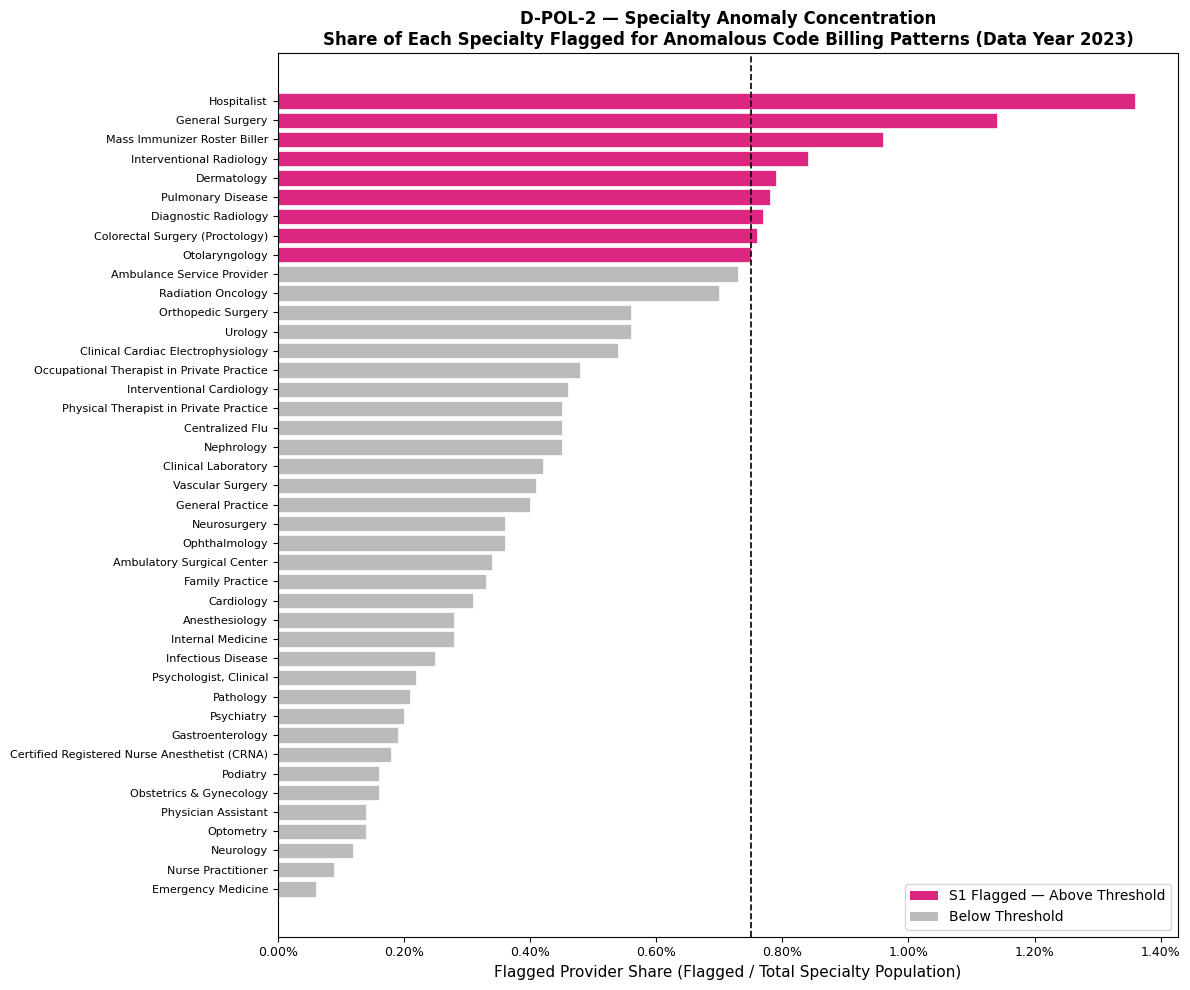

Saved: C:\Users\billm\Projects\Medicare\medicare-program-integrity\outputs\figures\specialty_concentration_v1.png


In [23]:
# DPOL2-06-VIZ-01
# Track 1 — Specialty anomaly concentration panel
# Horizontal bar chart — reliable specialties ranked by flagged share
# CVD-compliant IBM Carbon palette — tag D

# Filter to reliable specialties only
viz_s1 = (
    specialty_flagged[specialty_flagged['flagged_provider_count'] >= MIN_SPECIALTY_SIZE]
    .sort_values('specialty_flagged_share', ascending=True)
    .copy()
)

# Color by S1 flag
viz_s1['color'] = viz_s1['s1_concentration_flag'].apply(
    lambda x: CVD_PALETTE['tier1_oig'] if x == 1 else CVD_PALETTE['no_flag']
)

fig, ax = plt.subplots(figsize=(12, 10))

bars = ax.barh(
    viz_s1['provider_type'],
    viz_s1['specialty_flagged_share'],
    color=viz_s1['color'],
    edgecolor='white',
    linewidth=0.5
)

# Threshold line
ax.axvline(
    x=S1_CONCENTRATION_THRESHOLD,
    color='black',
    linestyle='--',
    linewidth=1.2,
    label=f'S1 Threshold = {S1_CONCENTRATION_THRESHOLD:.4f} (tag D)'
)

# Labels
ax.set_xlabel('Flagged Provider Share (Flagged / Total Specialty Population)', fontsize=11)
ax.set_title(
    'D-POL-2 — Specialty Anomaly Concentration\n'
    'Share of Each Specialty Flagged for Anomalous Code Billing Patterns (Data Year 2023)',
    fontsize=12, fontweight='bold'
)

# Format x-axis as percentage
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=2))

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=CVD_PALETTE['tier1_oig'], label='S1 Flagged — Above Threshold'),
    Patch(facecolor=CVD_PALETTE['no_flag'],   label='Below Threshold'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelsize=9)
plt.tight_layout()

outpath = FIGURES_DIR / 'specialty_concentration_v1.png'
plt.savefig(outpath, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {outpath}')

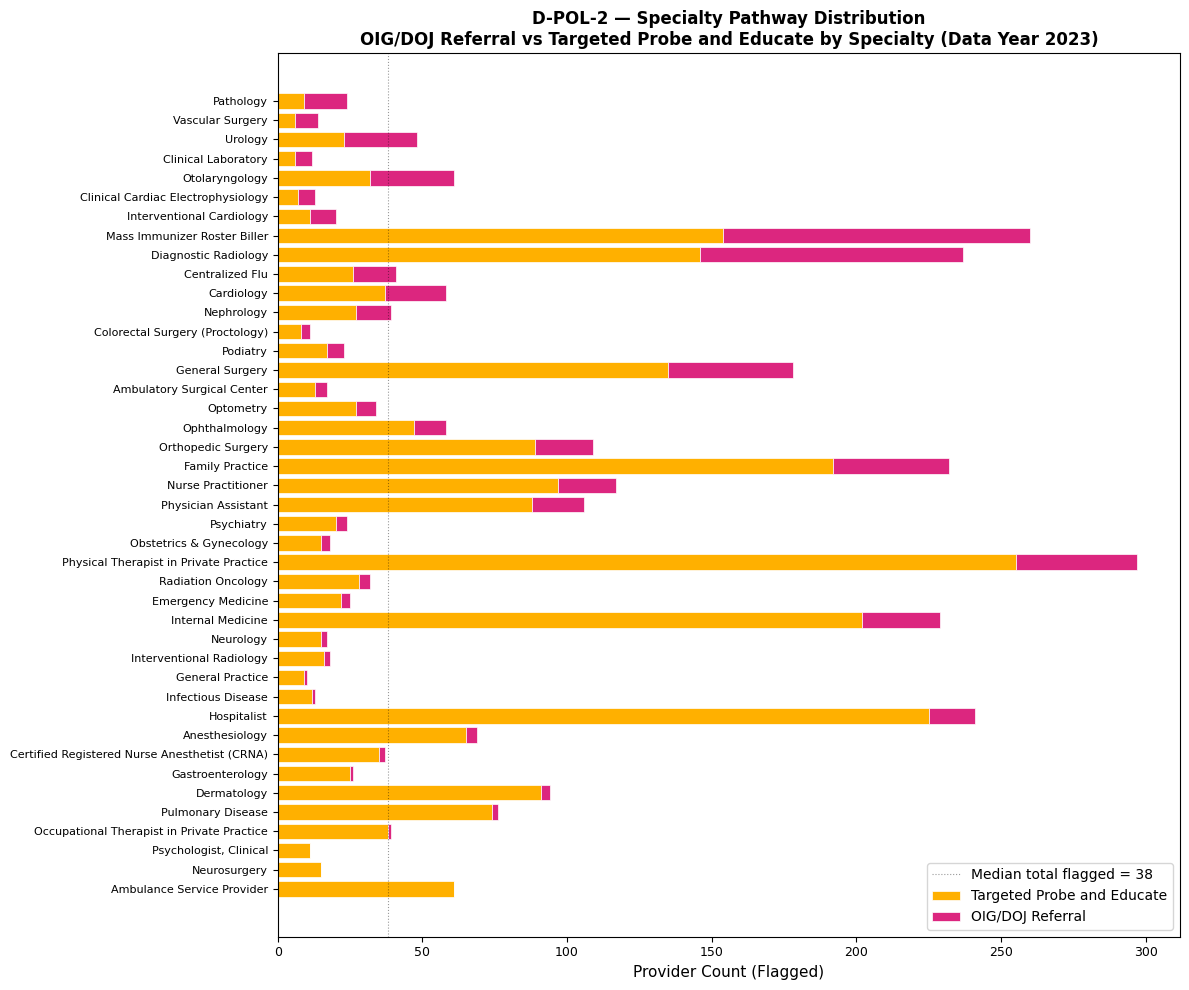

Saved: C:\Users\billm\Projects\Medicare\medicare-program-integrity\outputs\figures\specialty_pathway_distribution_v1.png


In [24]:
# DPOL2-06-VIZ-02
# Track 1 — OIG vs TPE specialty pathway distribution
# Stacked bar chart — reliable specialties ranked by OIG share
# CVD-compliant IBM Carbon palette — tag D

# Filter to reliable specialties only
viz_s2 = (
    pathway_wide[pathway_wide['total_flagged'] >= MIN_SPECIALTY_SIZE]
    .sort_values('oig_share', ascending=True)
    .copy()
)

fig, ax = plt.subplots(figsize=(12, 10))

# Stacked bars — TPE first (bottom), OIG on top
ax.barh(
    viz_s2['provider_type'],
    viz_s2['Targeted Probe and Educate'],
    color=CVD_PALETTE['tier2_tpe'],
    label='Targeted Probe and Educate',
    edgecolor='white',
    linewidth=0.5
)
ax.barh(
    viz_s2['provider_type'],
    viz_s2['OIG/DOJ Referral'],
    left=viz_s2['Targeted Probe and Educate'],
    color=CVD_PALETTE['tier1_oig'],
    label='OIG/DOJ Referral',
    edgecolor='white',
    linewidth=0.5
)

# Threshold line — OIG share threshold
# Convert to provider count scale for stacked bar
# Use axvline on oig_share * total_flagged — instead draw on a twin axis
# Simpler: annotate threshold as text note
ax.axvline(
    x=viz_s2['total_flagged'].median(),
    color='black',
    linestyle=':',
    linewidth=0.8,
    alpha=0.4,
    label=f'Median total flagged = {viz_s2["total_flagged"].median():.0f}'
)

ax.set_xlabel('Provider Count (Flagged)', fontsize=11)
ax.set_title(
    'D-POL-2 — Specialty Pathway Distribution\n'
    'OIG/DOJ Referral vs Targeted Probe and Educate by Specialty (Data Year 2023)',
    fontsize=12, fontweight='bold'
)

ax.legend(loc='lower right', fontsize=10)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelsize=9)
plt.tight_layout()

outpath = FIGURES_DIR / 'specialty_pathway_distribution_v1.png'
plt.savefig(outpath, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {outpath}')

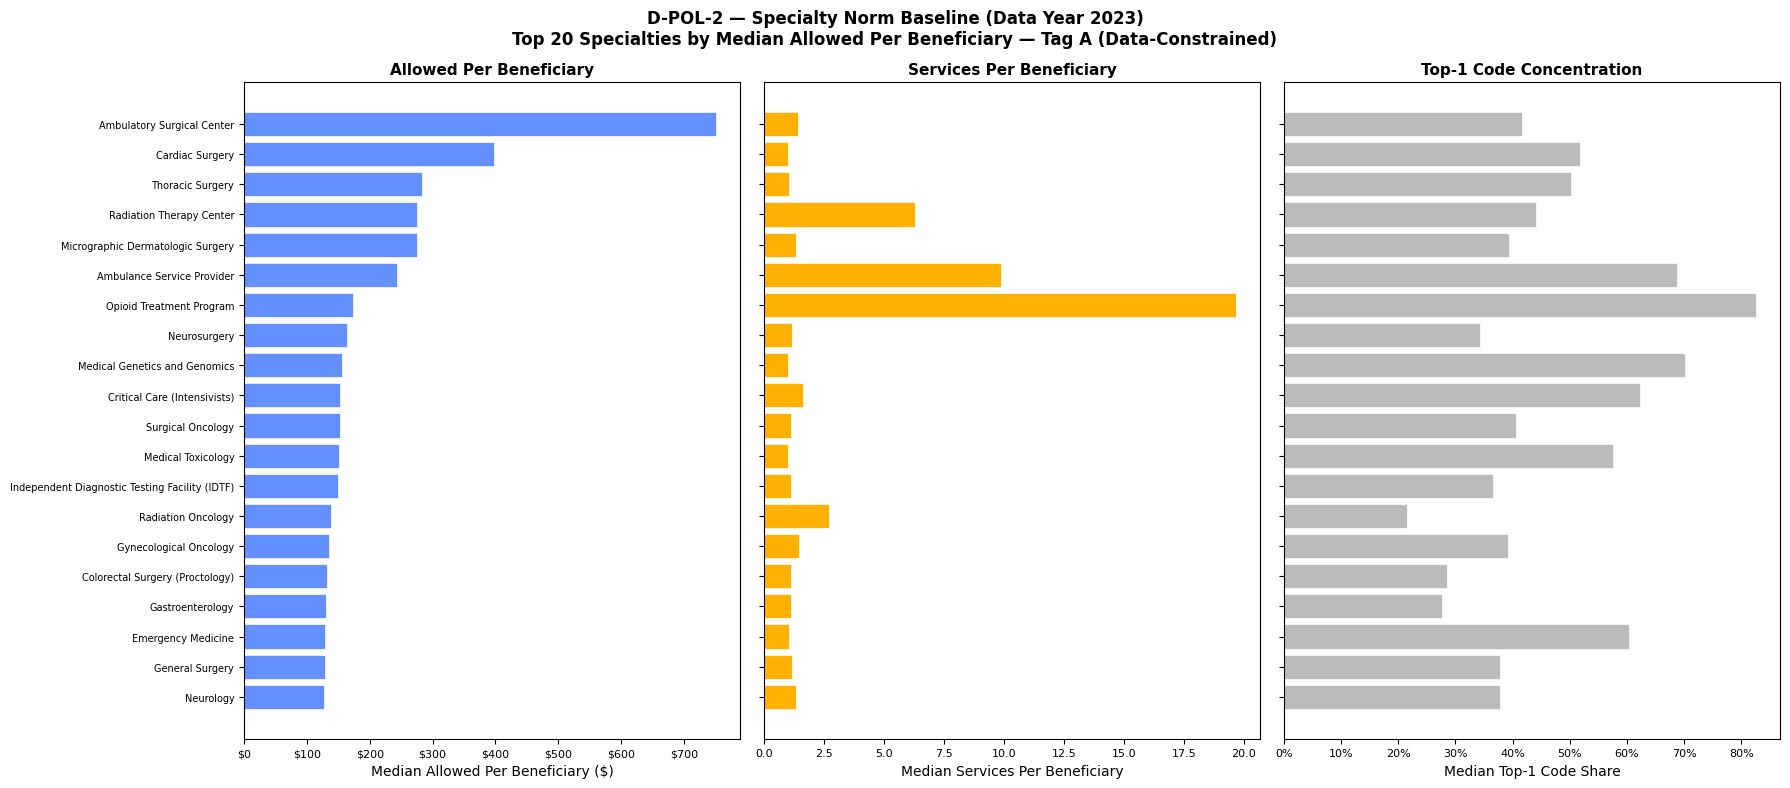

Saved: C:\Users\billm\Projects\Medicare\medicare-program-integrity\outputs\figures\specialty_baseline_v1.png — tag A (data-constrained)


In [25]:
# DPOL2-06-VIZ-03
# Track 2 — Specialty norm baseline visualization
# Top specialties by median allowed per beneficiary — Data Year 2023
# CVD-compliant IBM Carbon palette — tag A (data-constrained)

# Top N reliable specialties by median allowed per bene
viz_baseline = (
    df_baseline_reliable
    .sort_values('median_allowed_per_bene', ascending=True)
    .tail(TOP_N_DISPLAY)
    .copy()
)

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# --- Panel 1 — Median Allowed Per Beneficiary ---
axes[0].barh(
    viz_baseline['provider_type'],
    viz_baseline['median_allowed_per_bene'],
    color=CVD_PALETTE['tier3_edltr'],
    edgecolor='white',
    linewidth=0.5
)
axes[0].set_xlabel('Median Allowed Per Beneficiary ($)', fontsize=10)
axes[0].set_title('Allowed Per Beneficiary', fontsize=11, fontweight='bold')
axes[0].tick_params(axis='y', labelsize=7)
axes[0].tick_params(axis='x', labelsize=8)
axes[0].xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f'${x:,.0f}')
)

# --- Panel 2 — Median Services Per Beneficiary ---
axes[1].barh(
    viz_baseline['provider_type'],
    viz_baseline['median_services_per_bene'],
    color=CVD_PALETTE['tier2_tpe'],
    edgecolor='white',
    linewidth=0.5
)
axes[1].set_xlabel('Median Services Per Beneficiary', fontsize=10)
axes[1].set_title('Services Per Beneficiary', fontsize=11, fontweight='bold')
axes[1].tick_params(axis='y', labelsize=7)
axes[1].tick_params(axis='x', labelsize=8)
axes[1].set_yticklabels([])

# --- Panel 3 — Median Top-1 Code Share ---
axes[2].barh(
    viz_baseline['provider_type'],
    viz_baseline['median_top1_share'],
    color=CVD_PALETTE['no_flag'],
    edgecolor='white',
    linewidth=0.5
)
axes[2].set_xlabel('Median Top-1 Code Share', fontsize=10)
axes[2].set_title('Top-1 Code Concentration', fontsize=11, fontweight='bold')
axes[2].tick_params(axis='y', labelsize=7)
axes[2].tick_params(axis='x', labelsize=8)
axes[2].set_yticklabels([])
axes[2].xaxis.set_major_formatter(
    mticker.PercentFormatter(xmax=1, decimals=0)
)

fig.suptitle(
    'D-POL-2 — Specialty Norm Baseline (Data Year 2023)\n'
    'Top 20 Specialties by Median Allowed Per Beneficiary — Tag A (Data-Constrained)',
    fontsize=12, fontweight='bold'
)

plt.tight_layout()

outpath = FIGURES_DIR / 'specialty_baseline_v1.png'
plt.savefig(outpath, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {outpath} — tag A (data-constrained)')

<!-- DPOL2-07-OUTPUT-00 -->
## Section 7 — Output

Write three parquet output files with round-trip verification.

- `specialty_pattern_flags_v1.parquet` — Track 1 specialty flag summary (tag D)
- `specialty_baseline_v1.parquet` — Track 2 baseline metrics (tag A)
- `specialty_pathway_detail_v1.parquet` — Pathway detail by specialty (tag D)

In [26]:
# DPOL2-07-OUTPUT-01
# Write three parquet output files — round-trip verification for all three

# --- File 1 — specialty_pattern_flags_v1.parquet (tag D) ---
out_flags = PROCESSED_DIR / 'specialty_pattern_flags_v1.parquet'
specialty_summary.to_parquet(out_flags, index=False)
verify_flags = pd.read_parquet(out_flags)
assert len(verify_flags) == len(specialty_summary), 'FAIL: specialty_pattern_flags round-trip mismatch'
print(f'PASS — specialty_pattern_flags_v1.parquet written and verified')
print(f'       {len(verify_flags):,} rows | {verify_flags.shape[1]} cols | tag D')

# --- File 2 — specialty_baseline_v1.parquet (tag A) ---
out_baseline = PROCESSED_DIR / 'specialty_baseline_v1.parquet'
df_baseline.to_parquet(out_baseline, index=False)
verify_baseline = pd.read_parquet(out_baseline)
assert len(verify_baseline) == len(df_baseline), 'FAIL: specialty_baseline round-trip mismatch'
print(f'PASS — specialty_baseline_v1.parquet written and verified')
print(f'       {len(verify_baseline):,} rows | {verify_baseline.shape[1]} cols | tag A (data-constrained)')

# --- File 3 — specialty_pathway_detail_v1.parquet (tag D) ---
out_pathway = PROCESSED_DIR / 'specialty_pathway_detail_v1.parquet'
pathway_wide.to_parquet(out_pathway, index=False)
verify_pathway = pd.read_parquet(out_pathway)
assert len(verify_pathway) == len(pathway_wide), 'FAIL: specialty_pathway_detail round-trip mismatch'
print(f'PASS — specialty_pathway_detail_v1.parquet written and verified')
print(f'       {len(verify_pathway):,} rows | {verify_pathway.shape[1]} cols | tag D')

print(f'\n=== Output Summary ===')
print(f'All three parquet files written and round-trip verified.')
print(f'Location: {PROCESSED_DIR}')
print(f'\nFiles written:')
print(f'  specialty_pattern_flags_v1.parquet  — Track 1 specialty flag summary (tag D)')
print(f'  specialty_baseline_v1.parquet       — Track 2 baseline metrics (tag A)')
print(f'  specialty_pathway_detail_v1.parquet — Pathway detail by specialty (tag D)')

PASS — specialty_pattern_flags_v1.parquet written and verified
       74 rows | 11 cols | tag D
PASS — specialty_baseline_v1.parquet written and verified
       104 rows | 7 cols | tag A (data-constrained)
PASS — specialty_pathway_detail_v1.parquet written and verified
       74 rows | 6 cols | tag D

=== Output Summary ===
All three parquet files written and round-trip verified.
Location: C:\Users\billm\Projects\Medicare\medicare-program-integrity\data\processed

Files written:
  specialty_pattern_flags_v1.parquet  — Track 1 specialty flag summary (tag D)
  specialty_baseline_v1.parquet       — Track 2 baseline metrics (tag A)
  specialty_pathway_detail_v1.parquet — Pathway detail by specialty (tag D)


<!-- DPOL2-08-EVIDENCE-00 -->
## Section 8 — Evidence Log

Summary of all analytical outputs produced in this notebook.
All entries tagged O/D/I/A per project evidence standard.
Mirrors entries in decisions/D-POL-2_specialty_shift/evidence_log.md.

In [2]:
# DPOL2-08-EVIDENCE-01
# Evidence log summary — E-DPOL2-01 through E-DPOL2-08
# All outputs tagged O/D/I/A per project evidence standard

print('=' * 70)
print('EVIDENCE LOG — D-POL-2 Specialty Pattern Shift')
print('Notebook: D-POL-2_specialty_shift.ipynb')
print('Date: February 2026')
print('=' * 70)

print('''
E-DPOL2-01 | Tag D | Accepted
Source     : df_specialty — flagged providers with specialty assignments
             and full population denominators
Cell       : DPOL2-03-PREP-01
Result     : 3,182 providers | 74 unique Provider Types | 0 null types
             0 null pathway assignments
Relevance  : Foundation dataset for all Track 1 dimension scoring

E-DPOL2-02 | Tag D | Accepted
Source     : specialty_flagged — S1 Specialty Anomaly Concentration
Cell       : DPOL2-04-SCORE-01
Result     : 74 specialties scored | 32 neutral (flagged count < 10)
             9 specialties flagged above threshold
             Threshold: 0.0075 — derived from observed distribution
             Top specialty: Hospitalist (0.0136 flagged share)
Relevance  : Identifies specialties with disproportionate provider
             concentration among anomalous billing patterns

E-DPOL2-03 | Tag D | Accepted
Source     : pathway_wide — S2 Pathway Stratification by Specialty
Cell       : DPOL2-04-SCORE-02
Result     : 74 specialties scored | 32 neutral (total flagged < 10)
             11 specialties flagged above threshold
             Threshold: 0.35 — derived from observed distribution
             Top reliable specialty: Pathology (0.625 OIG share)
Relevance  : Identifies specialties with disproportionate OIG/DOJ
             referral routing among flagged providers

E-DPOL2-04 | Tag A | Accepted — data-constrained
Source     : df_baseline — S3 Specialty Norm Baseline
Cell       : DPOL2-04-SCORE-03
Result     : 104 specialties | 101 reliable baselines (>= 10 providers)
             Baseline year: 2023
             Metrics: median_allowed_per_bene, median_services_per_bene,
             median_top1_share
             Top allowed per bene: Ambulatory Surgical Center ($751.57)
Relevance  : Data Year 2023 reference baseline for future temporal
             shift detection. Tag resolves to D when Data Year 2024+
             incorporated.

E-DPOL2-05 | Tag A | Accepted — data-constrained
Source     : detect_specialty_shift() function
Cell       : DPOL2-04-SCORE-04
Result     : Parameterized shift detection framework defined and ready
             Shift magnitude threshold: 0.20 (PROVISIONAL)
             Minimum provider count: 10
             Status: Awaiting Data Year 2024 or later
Relevance  : S4 temporal shift detection framework fully documented
             and operationally ready. Tag resolves to D when multi-year
             data available.

E-DPOL2-06 | Tag D | Accepted
Source     : specialty_concentration_v1.png /
             specialty_pathway_distribution_v1.png
Cells      : DPOL2-06-VIZ-01 / DPOL2-06-VIZ-02
Result     : Two Track 1 visualizations produced and saved
             Concentration panel — 9 flagged specialties clearly
             separated from broader distribution
             Pathway panel — PT dominates volume; Pathology/Vascular
             Surgery/Urology show high OIG share on small populations
Relevance  : Track 1 policy visualization outputs

E-DPOL2-07 | Tag A | Accepted — data-constrained
Source     : specialty_baseline_v1.png
Cell       : DPOL2-06-VIZ-03
Result     : Three-panel baseline visualization produced and saved
             Ambulatory Surgical Center leads allowed per bene ($751)
             Opioid Treatment Program leads services per bene (~20)
             and top-1 code concentration (~83%)
Relevance  : Track 2 baseline visualization — Data Year 2023 reference
             only. Tag resolves to D when multi-year data available.

E-DPOL2-08 | Tag D / A | Accepted
Source     : Three parquet output files
Cell       : DPOL2-07-OUTPUT-01
Result     : specialty_pattern_flags_v1.parquet  — 74 rows | 11 cols | tag D
             specialty_baseline_v1.parquet       — 104 rows | 7 cols  | tag A
             specialty_pathway_detail_v1.parquet — 74 rows  | 6 cols  | tag D
             All round-trip verified
Relevance  : Persistent outputs for recommendation memo and
             downstream D-OPS-1 module

NOTE — Track 2 Data Constraint:
E-DPOL2-04, E-DPOL2-05, E-DPOL2-07 tagged A — single data year.
All Track 2 parameters and detection logic fully documented and
operationally ready. Entries resolve to D when Data Year 2024+
incorporated.

Three specialties with BOTH S1 and S2 dimensions firing:
  Mass Immunizer Roster Biller — flagged share 0.0096 | OIG share 0.408
  Diagnostic Radiology         — flagged share 0.0077 | OIG share 0.384
  Otolaryngology               — flagged share 0.0075 | OIG share 0.475
''')

print('=' * 70)
print('All evidence entries complete. D-POL-2 notebook execution finished.')
print('=' * 70)

EVIDENCE LOG — D-POL-2 Specialty Pattern Shift
Notebook: D-POL-2_specialty_shift.ipynb
Date: February 2026

E-DPOL2-01 | Tag D | Accepted
Source     : df_specialty — flagged providers with specialty assignments
             and full population denominators
Cell       : DPOL2-03-PREP-01
Result     : 3,182 providers | 74 unique Provider Types | 0 null types
             0 null pathway assignments
Relevance  : Foundation dataset for all Track 1 dimension scoring

E-DPOL2-02 | Tag D | Accepted
Source     : specialty_flagged — S1 Specialty Anomaly Concentration
Cell       : DPOL2-04-SCORE-01
Result     : 74 specialties scored | 32 neutral (flagged count < 10)
             9 specialties flagged above threshold
             Threshold: 0.0075 — derived from observed distribution
             Top specialty: Hospitalist (0.0136 flagged share)
Relevance  : Identifies specialties with disproportionate provider
             concentration among anomalous billing patterns

E-DPOL2-03 | Tag D | Accept